In [1]:
# !pip install uv
# !uv pip install git+https://github.com/ysenarath/AIT-724-HandsOn-2.git

In [2]:
import copy
import gzip
import os
import random
import shutil
import zipfile
from datetime import timedelta
from pathlib import Path
from typing import Any, Callable, cast

import community as community_louvain
import holoviews as hv
import hvplot.networkx as hvnx
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from networkx.drawing.layout import forceatlas2_layout
from networkx.drawing.nx_pydot import graphviz_layout
from tqdm import auto as tqdm

forceatlas2_layout = cast(Callable[..., Any], forceatlas2_layout)

hv.extension("bokeh")

In [3]:
def display_network(
    G: nx.Graph,
    sample_size: int | None = None,
    date_format: str = "%Y-%m-%d %H:%M:%S",
    layout: str = "forceatlas2",
    layout_kwargs: dict[str, Any] | None = None,
    node_size: int = 10,
    arrowhead_length: float = 0.01,
):
    # Utility function to visualize a NetworkX graph using hvplot
    # Sample graph to manageable size
    if sample_size is not None and len(G.edges) > sample_size:
        # nodes_sample = random.sample(list(G.nodes()), sample_size)
        # T = copy.deepcopy(G.subgraph(nodes_sample))
        # sample edges and then select the subgraph induced by those edges
        edges_sample = random.sample(list(G.edges()), sample_size)
        T = copy.deepcopy(G.edge_subgraph(edges_sample))
    else:
        T = copy.deepcopy(G)

    # Convert Timestamp attributes to strings
    for n, data in T.nodes(data=True):
        for k, v in list(data.items()):
            if isinstance(v, pd.Timestamp):
                data[k] = v.strftime(date_format)

    for u, v, data in T.edges(data=True):
        for k, val in list(data.items()):
            if isinstance(val, pd.Timestamp):
                data[k] = val.strftime(date_format)

    if layout == "forceatlas2":
        default_kwargs = {
            "max_iter": 100,
            "jitter_tolerance": 1.0,
            "scaling_ratio": 2.0,
            "gravity": 1.0,
        }
        default_kwargs.update(layout_kwargs or {})
        pos = forceatlas2_layout(T, **default_kwargs)
    else:
        pos = graphviz_layout(T, prog=layout or "neato")

    # Create hvplot
    plot = hvnx.draw(
        T,
        pos,
        node_size=node_size,
        node_color="lightblue",
        edge_color="gray",
        with_labels=True,
        # arrow head size = 0.02,
        arrows=True,
        arrowhead_length=arrowhead_length,
    ).opts(
        width=900,
        height=700,
        tools=["hover", "box_zoom", "wheel_zoom", "save", "reset"],
        title=f"Interactive Graph (|N|={len(T)}, |E|={len(T.edges)})",
    )

    # Add hover info dynamically
    hover_data = []
    for n, d in T.nodes(data=True):
        hover_data.append({"id": n, **d})
        # You can attach hover info via node attributes if needed

    return plot

# Download the Files

- The files are available at https://snap.stanford.edu/data/higgs-twitter.html

- Base URL: https://snap.stanford.edu/data/higgs-*

| File Name                   | Description                                                                                    |
| --------------------------- | ---------------------------------------------------------------------------------------------- |
| social_network.edgelist.gz  | Friends/follower graph (directed)                                                              |
| retweet_network.edgelist.gz | Graph of who retweets whom (directed and weighted)                                             |
| reply_network.edgelist.gz   | Graph of who replies to who (directed and weighted)                                            |
| mention_network.edgelist.gz | Graph of who mentions whom (directed and weighted)                                             |
| higgs-activity_time.txt.gz  | The dataset provides information about activity on Twitter during the discovery of Higgs boson |


In [4]:
def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get("content-length", 0))
        with (
            open(local_filename, "wb") as f,
            tqdm.tqdm(
                desc=local_filename,
                total=total_size,
                unit="iB",
                unit_scale=True,
                unit_divisor=1024,
            ) as bar,
        ):
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                bar.update(len(chunk))
    return local_filename


def unzip_file(zip_path, extract_to):
    if zipfile.is_zipfile(zip_path):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)
    elif zip_path.endswith(".gz"):
        with gzip.open(zip_path, "rb") as f_in:
            with open(os.path.splitext(zip_path)[0], "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)


def main():
    base_url = "https://snap.stanford.edu/data/higgs-"
    files = [
        "social_network.edgelist.gz",
        "retweet_network.edgelist.gz",
        "reply_network.edgelist.gz",
        "mention_network.edgelist.gz",
        "activity_time.txt.gz",
    ]
    dest_folder = "higgs_twitter_data"

    for file_name in files:
        url = base_url + file_name
        output_path = Path(dest_folder) / ("higgs-" + file_name.replace(".gz", ""))
        if output_path.exists():
            print(f"{file_name} already exists. Skipping download.")
            continue
        print(f"Downloading {url}...")
        downloaded_file = download_file(url, dest_folder)
        print(f"Unzipping {downloaded_file}...")
        unzip_file(downloaded_file, dest_folder)
        os.remove(downloaded_file)  # Remove the compressed file after extraction
        print(f"Finished processing {file_name}.\n")


main()

social_network.edgelist.gz already exists. Skipping download.
retweet_network.edgelist.gz already exists. Skipping download.
reply_network.edgelist.gz already exists. Skipping download.
mention_network.edgelist.gz already exists. Skipping download.
activity_time.txt.gz already exists. Skipping download.


# Understanding Edge List File Format

- For this exercise, we will only explore the the activity time file: `higgs-activity_time.txt.gz`
- This file contains four columns: userA userB timestamp interaction-type
- Every edge is directed from userA to userB (e.g., userA replies to userB, this means information flows from userB to userA)
- First let's try to load this file using pandas and explore its contents.


In [5]:
TIMESTAMP = "timestamp"

df = pd.read_csv(
    os.path.join("higgs_twitter_data", "higgs-activity_time.txt"),
    sep=" ",
    header=None,
    names=["source", "target", TIMESTAMP, "type"],
)
print(f"Total interactions in dataset: {len(df)}")

# Convert timestamp to datetime object
df[TIMESTAMP] = pd.to_datetime(df[TIMESTAMP], unit="s")

# let's look at the distribution of interaction types
interaction_counts = df["type"].value_counts()
print("Interaction type distribution:")
print(interaction_counts)

Total interactions in dataset: 563069
Interaction type distribution:
type
RT    354930
MT    171237
RE     36902
Name: count, dtype: int64


In [6]:
df = df[df["type"] == "RE"]
start_date = df[TIMESTAMP].min()

# If one is interested in building a network of how information flows,
#   then the direction of RT should be reversed when used in the analysis.
#   ref. https://snap.stanford.edu/data/higgs-twitter.html
df = df.rename(columns={"source": "target", "target": "source"})

total_number_of_nodes = df[["source", "target"]].stack().nunique()
total_number_of_edges = len(df)

print(f"Total number of unique nodes: {total_number_of_nodes}")
print(f"Total number of edges: {total_number_of_edges}")

df.head(5)

Total number of unique nodes: 38918
Total number of edges: 36902


,target,source,timestamp,type
1,223789,213163,2012-07-01 00:02:52,RE
9,184615,364376,2012-07-01 00:12:03,RE
15,364376,184615,2012-07-01 00:15:50,RE
31,325916,325915,2012-07-01 00:38:20,RE
36,325916,325915,2012-07-01 00:42:08,RE


In [7]:
# let's look at the time range of the interactions
min_time = df[TIMESTAMP].min()
max_time = df[TIMESTAMP].max()
print(f"Time range of interactions: {min_time} to {max_time}")

Time range of interactions: 2012-07-01 00:02:52 to 2012-07-07 23:58:50


In [8]:
G: nx.DiGraph = nx.from_pandas_edgelist(
    df,
    source="source",
    target="target",
    edge_attr=[
        TIMESTAMP,
        "type",  # type will always be "RE" here (or whatever we filtered for)
    ],
    create_using=nx.DiGraph,
)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 38918 nodes and 32523 edges.


In [9]:
display_network(G, sample_size=100, layout_kwargs={"max_iter": 200})

:Overlay
   .Graph.I  :Graph   [start,end]   (timestamp,type)
   .Labels.I :Labels   [x,y]   (index)

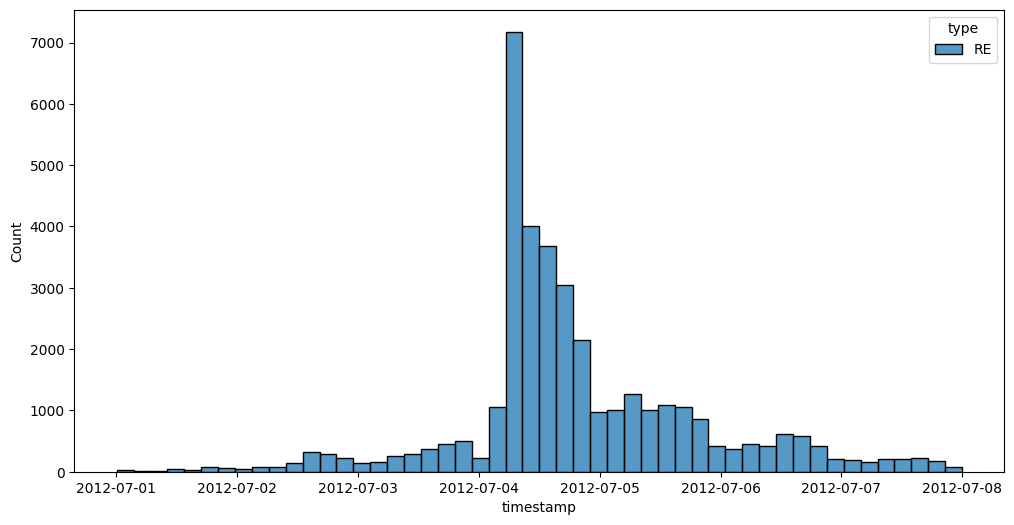

In [10]:
# Visualise early diffusion: e.g., plot number of new retweeters over time.

plt.figure(figsize=(12, 6))

sns.histplot(
    df,
    x=TIMESTAMP,
    bins=50,
    kde=False,
    hue="type",
    multiple="stack",
)

plt.show()


In [11]:
# Compute degree
print("Computing node degrees...")

degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, "degree")

# in degree
in_degree_dict = dict(G.in_degree())
nx.set_node_attributes(G, in_degree_dict, "in_degree")

Computing node degrees...


In [12]:
# Compute betweenness centrality

# # print("Computing betweenness centrality...")
# # takes around 15 mins-45mins
# centrality_dict = nx.betweenness_centrality(G)
# nx.set_node_attributes(G, centrality_dict, "betweenness_centrality")

# follwing is a more efficient way using igraph, commented out for now

# compute betweenness centrality for all vertices using igraph
print("Computing betweenness centrality using igraph...")
G_ig = ig.Graph.from_networkx(G)
vertex_betweenness = G_ig.betweenness()

# put it back to networkx graph
# betweenness_dict = {v.index: float(vertex_betweenness[v.index]) for v in G_ig.vs}
names = [v["_nx_name"] for v in G_ig.vs]
betweenness_dict = dict(zip(names, vertex_betweenness))
nx.set_node_attributes(G, betweenness_dict, "betweenness_centrality")

Computing betweenness centrality using igraph...


In [13]:
# closeness centrality
print("Computing closeness centrality...")

closeness_dict = nx.closeness_centrality(G)

nx.set_node_attributes(G, closeness_dict, "closeness_centrality")

Computing closeness centrality...


In [14]:
# Run PageRank algorithm
print("Computing PageRank...")

pagerank_dict = nx.pagerank(G, alpha=0.85)

nx.set_node_attributes(G, pagerank_dict, "pagerank")

Computing PageRank...


In [15]:
# Compute clustering coefficient
print("Computing clustering coefficient...")

clustering_dict = nx.clustering(G.to_undirected())

nx.set_node_attributes(G, clustering_dict, "clustering_coefficient")

Computing clustering coefficient...


In [16]:
# Add modularity class using the Louvain method
partition = community_louvain.best_partition(G.to_undirected())

nx.set_node_attributes(G, partition, "modularity_class")

In [17]:
# Common measure for quantifying influence of bloggers is to use in-degree centrality
# - This is the number of users who follow a person on Twitter.
# In-links are sparse
# - More detailed analysis is required to measure influence

in_degrees: dict[str, float] = nx.get_node_attributes(G, "in_degree")
threshold = np.percentile(list(in_degrees.values()), 99)  # top 1%

influencers = [n for n, deg in in_degrees.items() if deg >= threshold]
regulars = [n for n in G.nodes if n not in influencers]

print(f"Influencers: {len(influencers)} | Regulars: {len(regulars)}")

# add this back to the network G
influencer_dict = {n: (n in influencers) for n in G.nodes}
nx.set_node_attributes(G, influencer_dict, "is_influencer")

Influencers: 418 | Regulars: 38500


In [18]:
# show node & edge attributes

print("Node attribute names for first node:")
first_node = list(G.nodes)[0]
print(G.nodes[first_node].keys())

print("Edges attribute names for first node:")
first_edge = list(G.edges)[0]
print(G.edges[first_edge].keys())

Node attribute names for first node:
dict_keys(['degree', 'in_degree', 'betweenness_centrality', 'closeness_centrality', 'pagerank', 'clustering_coefficient', 'modularity_class', 'is_influencer'])
Edges attribute names for first node:
dict_keys(['timestamp', 'type'])


In [19]:
def group_timestamps(
    G: nx.DiGraph,
    node: Any,
    time_window: timedelta | None,
    timestamp_col: str = "timestamp",
) -> list[list[pd.Timestamp]]:
    """
    We can assume that the interactions are about the same post if it happens within time_window.
    We can use this function to group timestamps of edges (intractions) from a node (user)
    into clusters based on time_window.

    Example:
    |       |   |      |                |       |
    t1      t2  t3     t4               t5      t6

    i0: [t1], [t2], [t3], [t4], [t5], [t6]

    t2 - t1 < time_window, therefore merge
    i0: [t1, t2], [t3], [t4], [t5], [t6]

    t3 - t2 < time_window, therefore merge
    i0: [t1, t2, t3], [t4], [t5], [t6]

    t4 - t3 < time_window, therefore merge
    i0: [t1, t2, t3, t4], [t5], [t6]

    t5 - t4 >= time_window, therefore do not merge
    i1: [t1, t2, t3, t4], [t5, t6]
    """
    # Group timestamps of edges from a node into clusters based on time_window
    # - first, get all timestamps of edges from the node
    items = []
    for source, target, data in G.edges(node, data=True):
        dt = data[timestamp_col]
        items.append(dt)
    # - sort timestamps to ensure chronological order
    items = sorted(items)
    if time_window is None:
        # - if no time window is specified, return all timestamps as a single group
        groups = [items]
    else:
        # - cluster timestamps based on time_window
        groups = [[x] for x in items]
        i = 0
        while i < len(groups) - 1:
            # - if the time difference between two consecutive timestamps is less than time_window, merge them
            # -- groups[i][-1] is the last timestamp in the current group
            # -- groups[i + 1][0] is the first timestamp in the next group
            if (groups[i + 1][0] - groups[i][-1]) < time_window:
                groups[i].extend(groups[i + 1])
                # - remove the next group after merging
                # -- when groups[i + 1] is deleted, groups[i + 2] becomes the new groups[i + 1]
                del groups[i + 1]
                # - do not increment i, as we need to check the merged group with the new next one
            else:
                i += 1
    return groups


def build_cascade_from_root(
    G: nx.DiGraph,
    root: Any,
    timestamp_cluster: list[pd.Timestamp],
    visited: set,
    time_window: timedelta | None = None,
    timestamp_col: str = "timestamp",
) -> nx.DiGraph:
    # Start a cascade
    cascade_nodes = set([root])
    cascade_edges = dict()
    queue = [(root, ts) for ts in timestamp_cluster]
    visited.add(root)
    while queue:
        current, t_curr = queue.pop(0)
        neighbors = sorted(
            G.neighbors(current),
            key=lambda nbr: G.get_edge_data(current, nbr, default={})[timestamp_col],
        )
        for nbr in neighbors:
            edge = G.get_edge_data(current, nbr, default={})
            # typeof datetime is pandas.Timestamp
            t_edge = edge[timestamp_col]
            # convert to real time and print
            if time_window is not None and (t_edge - t_curr > time_window):
                continue
            if nbr not in visited:
                cascade_nodes.add(nbr)
                cascade_edges[(current, nbr)] = edge
                queue.append((nbr, t_edge))
                visited.add(nbr)
    cascade = nx.DiGraph()
    cascade.add_nodes_from(cascade_nodes)
    cascade_edges_with_data = [
        (src, tgt, data) for (src, tgt), data in cascade_edges.items()
    ]
    cascade.add_edges_from(cascade_edges_with_data)
    return cascade


def build_cascades(
    G: nx.DiGraph,
    time_window: timedelta | None = None,
    min_cascade_size: int = 1,
    timestamp_col: str = "timestamp",
) -> list[nx.DiGraph]:
    cascades = []
    visited = set()
    for root in G.nodes():
        if root in visited:
            continue
        for timestamp_cluster in group_timestamps(
            G, root, time_window=time_window, timestamp_col=timestamp_col
        ):
            cascade = build_cascade_from_root(
                G,
                root,
                timestamp_cluster=timestamp_cluster,
                visited=visited,
                time_window=time_window,
                timestamp_col=timestamp_col,
            )
            cascades.append(cascade)
    # filter cascades with size > 1
    cascades = [c for c in cascades if len(c) > min_cascade_size]
    return cascades

Total cascades found: 167
Largest cascade size: 3107


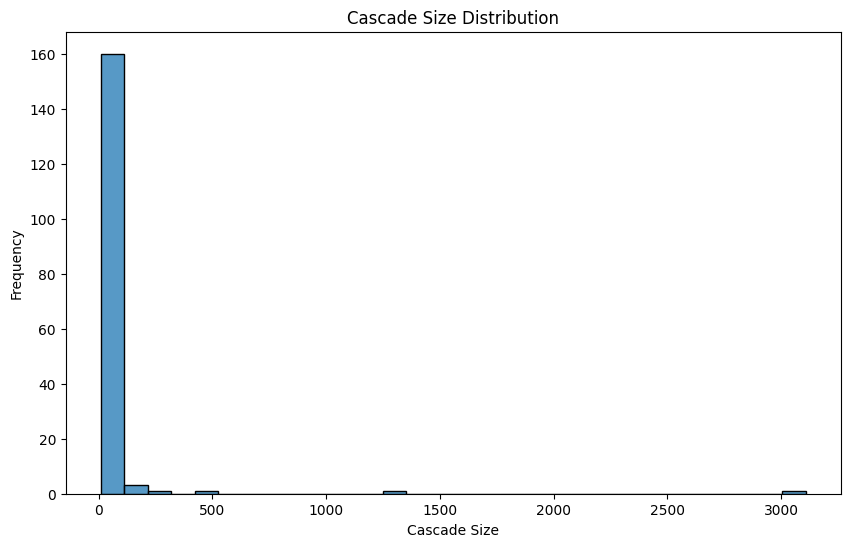

In [ ]:
cascades = build_cascades(G, time_window=None, min_cascade_size=10)
print(f"Total cascades found: {len(cascades)}")

largest_cascade = max(cascades, key=len)
print(f"Largest cascade size: {len(largest_cascade)}")

# size of the cascades
cascade_sizes = [len(c) for c in cascades]
plt.figure(figsize=(10, 6))
sns.histplot(cascade_sizes, bins=30, kde=False)
plt.title("Cascade Size Distribution")
plt.xlabel("Cascade Size")
plt.ylabel("Frequency")
plt.show()

Total cascades found: 49
Largest cascade size: 139


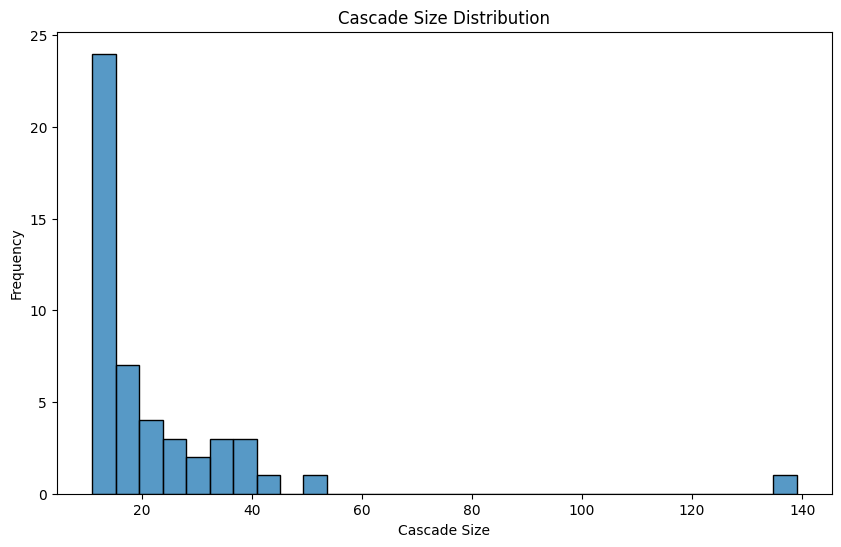

In [ ]:
cascades = build_cascades(G, time_window=timedelta(minutes=1), min_cascade_size=10)
print(f"Total cascades found: {len(cascades)}")

largest_cascade = max(cascades, key=len)
print(f"Largest cascade size: {len(largest_cascade)}")

# size of the cascades
cascade_sizes = [len(c) for c in cascades]
plt.figure(figsize=(10, 6))
sns.histplot(cascade_sizes, bins=30, kde=False)
plt.title("Cascade Size Distribution")
plt.xlabel("Cascade Size")
plt.ylabel("Frequency")
plt.show()

In [22]:
display_network(largest_cascade, layout="twopi")

:Overlay
   .Graph.I  :Graph   [start,end]   (timestamp,type)
   .Labels.I :Labels   [x,y]   (index)

In [23]:
# Get Node data about node 677
node_id = 677
print(f"Node {node_id} data:")
print(G.nodes[node_id])

Node 677 data:
{'degree': 1213, 'in_degree': 7, 'betweenness_centrality': 1216103.466666667, 'closeness_centrality': 0.001735830197054319, 'pagerank': 0.00011877828466371791, 'clustering_coefficient': 1.6487570432839944e-05, 'modularity_class': 8, 'is_influencer': True}


In [24]:
def get_roots(G: nx.DiGraph) -> list[Any]:
    # roots are nodes with in-degree 0
    roots = [n for n in G.nodes() if G.in_degree(n) == 0]
    return roots

In [ ]:
# compare the cascade sizes of influencers vs regular users
cascades = build_cascades(G, time_window=None, min_cascade_size=1)

for cascade in cascades:
    roots = get_roots(cascade)
    if not roots:
        continue
    # set cascade_size for the root nodes
    cascade_size = len(cascade)
    for root in roots:
        if "cascade_size" in G.nodes[root]:
            G.nodes[root]["cascade_size"] = max(
                G.nodes[root]["cascade_size"], cascade_size
            )
        else:
            G.nodes[root]["cascade_size"] = cascade_size

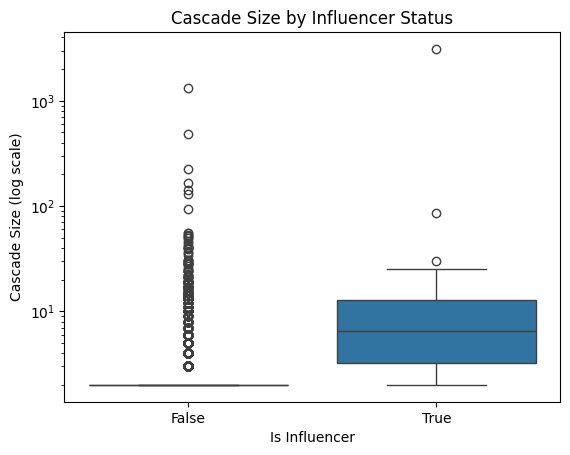

In [44]:
temp_data = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient="index")
temp_data = temp_data.dropna(subset=["cascade_size"])

sns.boxplot(
    data=temp_data,
    x="is_influencer",
    y="cascade_size",
)
plt.yscale("log")
plt.title("Cascade Size by Influencer Status")
plt.xlabel("Is Influencer")
plt.ylabel("Cascade Size (log scale)")
plt.show()